In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/DataIntelligenceApplications/')

---
_Here now check the step3 and step4 with this new environment._

### STEP#3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from environments.complete_environment import CompleteEnvironment
from data_generators.standard_generator import StandardDataGenerator
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB

In [2]:
src = 'src/basic007.json'

In [3]:
dg = StandardDataGenerator(filename=src)
margins = dg.get_margins()

In [5]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 8
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 8


In [6]:
selected_bid = 4

In [7]:
learners_to_test = [ThompsonSampling, UCB]
#learners_to_test = [UCB]
rewards_per_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []

In [8]:
for e in range(n_experiments):
    print(f'running experiment {e + 1}/{n_experiments}...\n')
    test_instances = []
    for learner in learners_to_test:
        test_instances.append((learner(arm_values=margins),
                               CompleteEnvironment(src=src)))
    for t in range(T):
        for learner, env in test_instances:
            learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            _ = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True) # past features not usefull here
            month_purchases = env.get_next_purchases_at_day(t, keep=False, filter_purchases=True)
            if month_purchases is not None:
                for arm, n_purchases in zip(past_arms, month_purchases):
                    learner.update_single_future_purchase(arm, n_purchases)
            pulled_arm = learner.pull_arm()
            daily_reward, _, _ = env.day_round(pulled_arm, selected_bid=selected_bid, fixed_adv=True)
            for outcome, cost in daily_reward:
                learner.update(pulled_arm, outcome, cost)
    for learner, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.LEARNER_NAME].append(learner.daily_collected_rewards)

running experiment 1/8...

running experiment 2/8...

running experiment 3/8...

running experiment 4/8...

running experiment 5/8...

running experiment 6/8...

running experiment 7/8...

running experiment 8/8...



In [9]:
margins = dg.get_margins()
classes = dg.get_classes()
conversion_rates = dg.get_conversion_rates(mode='all')
future_purchases = dg.get_future_purchases(mode='all')
number_of_clicks = dg.get_daily_clicks(mode='all')

costs_per_click = dg.get_costs_per_click(mode='aggregate', bid=selected_bid)
fixed_cost = costs_per_click[selected_bid]
fixed_n_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[selected_bid]).astype(int)
fractions = dg.get_class_distributions(selected_bid)

temp = (margins * np.average(conversion_rates * (1 + future_purchases),
                             axis=0,
                             weights=fractions) - fixed_cost) * fixed_n_clicks
aggr_opt_arm = np.argmax(temp)
aggr_opt = np.max(temp)

disaggr_opt = 0
opt_arms = []
disaggr_costs = dg.get_costs_per_click(mode='all')
for i, _ in enumerate(conversion_rates):
    t = (margins * conversion_rates[i] * (1 + future_purchases[i]) - disaggr_costs[i, selected_bid]) * \
                number_of_clicks[i, selected_bid]
    opt_arm = np.argmax(t)
    opt_value = np.max(t)
    opt_arms.append(opt_arm)
    disaggr_opt += opt_value

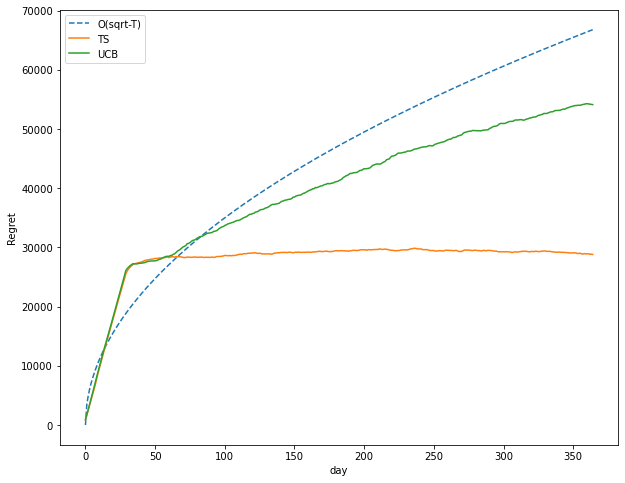

In [11]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(3500*np.sqrt(np.linspace(0,364,365)), '--')
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(aggr_opt - val, axis=0)))

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
#for val in days_of_split.values():
#    avg_days = np.mean(val, axis=0)
#    for day in avg_days:
#        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(['O(sqrt-T)']+list(rewards_per_experiment.keys()))
plt.show()

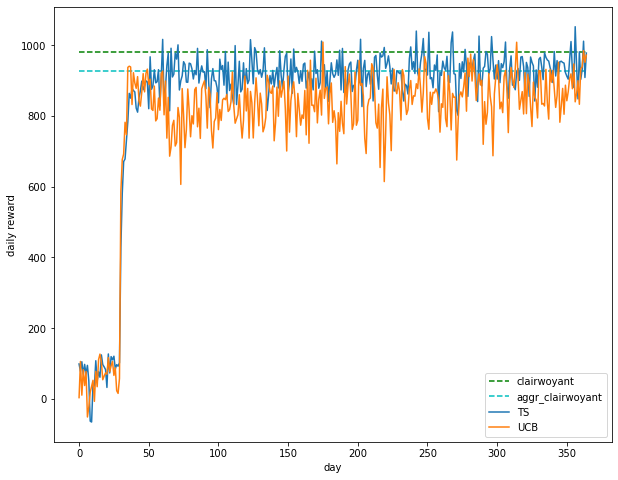

In [12]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

plt.legend(loc='best')
plt.show()

---
### STEP#4

In [13]:
from learners.pricing.contextual_learner import ContextualLearner
from utils.context_generator import ContextGenerator

In [15]:
selected_bid = 4
T = 365
n_experiments = 8
learners_to_test = [ThompsonSampling, UCB]
cg_start_from = 60
cg_confidence = 0.02
cg_frequency = 10

features = dg.get_features() 
fractions = dg.get_class_distributions(selected_bid)
bandit_args = {
            'arm_values': dg.get_margins()
}

In [16]:
rewards_per_experiment = {}
context_split_per_experiment = {}
days_of_split = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_per_experiment[learner.LEARNER_NAME] = []
    days_of_split[learner.LEARNER_NAME] = []

In [18]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'\nrunning experiment {e + 1}/{n_experiments}...\n')
    test_instances = []
    
    for learner in learners_to_test:
        context_learner = ContextualLearner(features, learner, **bandit_args)
        test_instances.append(
            (context_learner,
             CompleteEnvironment(src=src),
             ContextGenerator(features=features,
                              contextual_learner=context_learner,
                              update_frequency=cg_frequency,
                              start_from=cg_start_from,
                              confidence=cg_confidence,
                              verbose=1))
        )
    for t in range(T):
        for context_learner, env, context_generator in test_instances:
            #print(f'##### DAY {t} ######')
            context_learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            past_features = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True)
            month_purchases = env.get_next_purchases_at_day(t, keep=False, filter_purchases=True)
            if month_purchases is not None:
                context_learner.update_next_purchases(past_arms, month_purchases, past_features)

            pulled_arms = context_learner.pull_arm()
            daily_rewards, _, _ = env.day_round(pulled_arms, selected_bid=selected_bid, fixed_adv=True)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)
            
            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, 
                                                 daily_rewards, 
                                                 daily_users_features,
                                                 next_purchases=month_purchases, 
                                                 past_pulled_arms=past_arms,
                                                 past_features=past_features)
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())
        days_of_split[learner.base_learner_class.LEARNER_NAME].append(context_generator.metadata['SPLIT_DAYS'])
    
    # end -> save rhe results.


running experiment 1/8...


-------------------- RUNNING CONTEXT GENERATOR@t=60 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']

Analysis of the feature `feature-1`...

Analysis of the feature `feature-2`...
	Values after the split: [2.3935260263090377, 2.4807962391633724]
	Value before the split: 2.348657716178249

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': False} and {'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=60 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']

Analysis of the feature `feature-1`...

Analysis of the feature `feature-2`...
	Values after the split: [2.5382199962069687, 2.4291144547334858]
	Value before the split: 2.3068213647213307

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': Fal

	Values after the split: [0.7240525691355244]
	Value before the split: 0.5916106238889717

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': False, 'feature-2': False} and {'feature-1': False, 'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=170 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.0341252163664503]
	Value before the split: 1.0621449261594276


-------------------- RUNNING CONTEXT GENERATOR@t=180 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.0351304292153034]
	Value before the split: 1.0625863413106744


-------------------- RUNNING CONTEXT GENERATOR@t=190 [TS]--------------------
N_LEAVES: 1


	Values after the split: [4.1144625035094045]
	Value before the split: 4.056667086196798

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': True, 'feature-2': False} and {'feature-1': True, 'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=70 [UCB]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [0.6020886744761265]
	Value before the split: 0.7099571214231158

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [3.5043705883465077]
	Value before the split: 2.567674942184032

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': True, 'feature-2': False} and {'feature-1': True, 'feature-2': True}

-------------------- RUNNING CONTE

	Values after the split: [1.0170072857958128]
	Value before the split: 1.0403822127919513


-------------------- RUNNING CONTEXT GENERATOR@t=260 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.0198951225826434]
	Value before the split: 1.0438249197877851


-------------------- RUNNING CONTEXT GENERATOR@t=270 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.0216313390292204]
	Value before the split: 1.0456613100892231


-------------------- RUNNING CONTEXT GENERATOR@t=280 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Val


-------------------- RUNNING CONTEXT GENERATOR@t=110 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.0057839068079213]
	Value before the split: 1.0280996984925073

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [4.24883829653805]
	Value before the split: 4.305521838333206


-------------------- RUNNING CONTEXT GENERATOR@t=120 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [0.997316495983601]
	Value before the split: 1.026291432915239

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feat

	Values after the split: [4.191682695774681]
	Value before the split: 4.191676517139385

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': True, 'feature-2': False} and {'feature-1': True, 'feature-2': True}

running experiment 4/8...


-------------------- RUNNING CONTEXT GENERATOR@t=60 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']

Analysis of the feature `feature-1`...

Analysis of the feature `feature-2`...
	Values after the split: [2.419512285282569, 2.4955802312500133]
	Value before the split: 2.475006032742812

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': False} and {'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=60 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']

Analysis of the feature `feature-1`.

	Values after the split: [4.0699145660609775]
	Value before the split: 4.114256046794328


-------------------- RUNNING CONTEXT GENERATOR@t=80 [UCB]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.6599561066114754]
	Value before the split: 0.6897953129982295

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [4.174363975840176]
	Value before the split: 2.9133860336121677

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': True, 'feature-1': False} and {'feature-2': True, 'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=90 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['

	Values after the split: [4.107245695679492]
	Value before the split: 4.157852975959448


-------------------- RUNNING CONTEXT GENERATOR@t=200 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.7645246126570948]
	Value before the split: 0.924485463840754


-------------------- RUNNING CONTEXT GENERATOR@t=210 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [4.099150298575574]
	Value before the split: 4.152157743393336


-------------------- RUNNING CONTEXT GENERATOR@t=210 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values 

	Values after the split: [4.211014678323142]
	Value before the split: 4.265126412026396


-------------------- RUNNING CONTEXT GENERATOR@t=80 [UCB]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [0.7081300522967444]
	Value before the split: 1.1824678641082873

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [3.8095053835870387]
	Value before the split: 4.2629525755803055


-------------------- RUNNING CONTEXT GENERATOR@t=90 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [4.267832720630677]
	Value before the split: 4.2843497481718895


---------

	Values after the split: [0.8653495370225166]
	Value before the split: 0.8879904537945784

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [3.1357776101995247]
	Value before the split: 3.671898113230457


-------------------- RUNNING CONTEXT GENERATOR@t=90 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.0553013170992651]
	Value before the split: 1.1193856144627232

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [4.123632820865167]
	Value before the split: 4.198365964894883


-------------------- RUNNING CONTEXT GENERATOR@t=90 [UCB]--------------------
N_LEAVES: 2
- Evaluati

	Values after the split: [0.7394773279010418]
	Value before the split: 1.098114446915342

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [4.03495308820118]
	Value before the split: 3.921504980373243

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': True, 'feature-2': False} and {'feature-1': True, 'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=80 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.0057532568063512]
	Value before the split: 1.0973333378972239

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [4.2496243061690

	Values after the split: [4.176389483922936]
	Value before the split: 4.191031077033835


-------------------- RUNNING CONTEXT GENERATOR@t=210 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.0216979370299926]
	Value before the split: 1.0484257437045026

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [4.222371311385117]
	Value before the split: 4.198598606236691

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': True, 'feature-1': False} and {'feature-2': True, 'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=220 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['

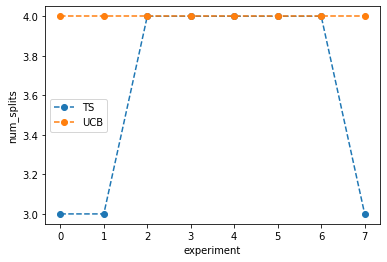

In [19]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_per_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_per_experiment.keys())
plt.show()

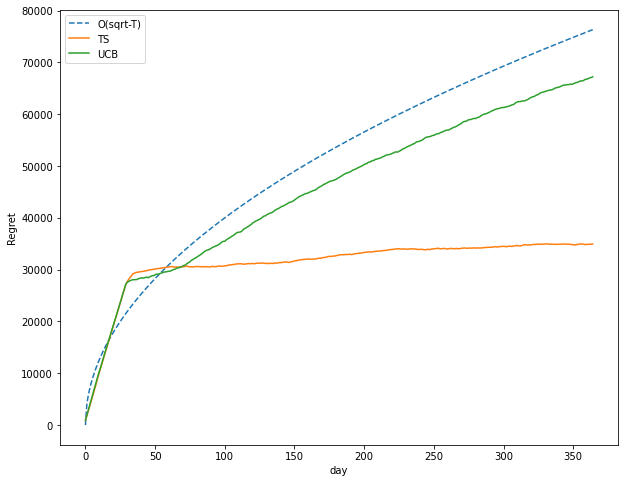

In [20]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(4000*np.sqrt(np.linspace(0,364,365)), '--')
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(disaggr_opt - val, axis=0)))

plt.legend(['O(sqrt-T)']+list(rewards_per_experiment.keys()))
plt.show()

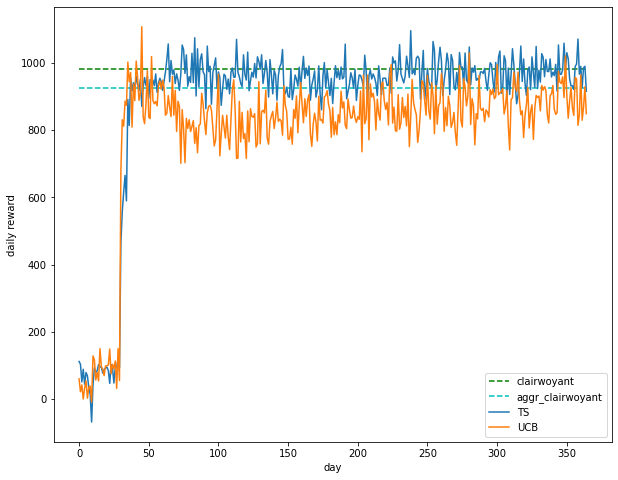

In [21]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

plt.legend(loc='best')
plt.show()